# Predição de links por métodos clássicos
Neste notebook exploramos a predição de links na base de dados de disciplinas dos alunos por meio de métodos clássicos.

In [1]:
from data_processing import load_student_data, get_optativas
dados = load_student_data()

dados['formados']

,ID_ANONIMO,CR,PERIODO,INGRESSO,CODIGO,ANO,PERIODO.1,NOTA,CH,SITUACAOALUNO
0,13236,"0,6826",10,12/07/07,IF68E,2012,1,"8,2",60,Formado
1,13236,"0,6826",10,12/07/07,IF35J,2007,2,7,60,Formado
2,13236,"0,6826",10,12/07/07,MA33K,2007,2,0,60,Formado
3,13236,"0,6826",10,12/07/07,F2D070,2007,2,"8,8",75,Formado
4,13236,"0,6826",10,12/07/07,E1D000,2007,2,0,30,Formado
...,...,...,...,...,...,...,...,...,...,...
30139,202261,"0,9013",10,05/03/18,EEE32,2021,1,"7,7",60,Formado
30140,202261,"0,9013",10,05/03/18,CSR31,2020,2,"8,5",30,Formado
30141,202261,"0,9013",10,05/03/18,CSR31,2020,1,-1,30,Formado
30142,202261,"0,9013",10,05/03/18,EEQ31,2019,2,"9,4",75,Formado


In [73]:
import networkx as nx
import matplotlib.pyplot as plt
import sklearn.model_selection as skl
import pandas as pd
from tqdm import tqdm

def get_subset_all(tipo_aluno : str):
    return dados[tipo_aluno]

def get_subset_split_bystudent(test_size : float, tipo_aluno : str):
    _subset, _ = skl.train_test_split(dados[tipo_aluno].ID_ANONIMO, test_size = test_size)
    data = dados[tipo_aluno][dados[tipo_aluno]["ID_ANONIMO"].isin(_subset)]
    return data

def get_subset_split_all(tipo_aluno : str):
    return skl.train_test_split(dados['formados'], test_size = test_size)

G = nx.Graph()
subset = get_subset_all('todos')

#print(subset.ID_ANONIMO.unique())

optativas = get_optativas()

disciplinas = subset.CODIGO.unique()

G.add_nodes_from(disciplinas)
G.add_nodes_from(subset.ID_ANONIMO.unique())

attrs = {id: {'ingresso': subset[subset['ID_ANONIMO'] == id]['INGRESSO'].values[0],
              'cr': subset[subset['ID_ANONIMO'] == id]['CR'].values[0],
             'situacao': subset[subset['ID_ANONIMO'] == id]['SITUACAOALUNO'].values[0]} for id in subset.ID_ANONIMO.unique()}
nx.set_node_attributes(G, attrs)

for x in subset.values:
    if(x[4] in disciplinas):
        x[7] = float(str(x[7]).replace(',','.'))
        if(x[7] != x[7] or x[7] <= 0):
            x[7] = 0.01
        G.add_edge(x[0], x[4], weight=1/x[7])

In [49]:
centrality = nx.degree_centrality(G)

centrality = sorted(centrality.items(), key=lambda item: -item[1])

#print("Degree centrality: ", centrality)

In [26]:
path = nx.shortest_path(G, source=202266, target=202701, weight="weight")
length = nx.shortest_path_length(G, source=202266, target = 202701, weight="weight")

print(f"Shortest path: {path}, Length: {length}")

Shortest path: [202266, 'CSG20', 202701], Length: 0.2


In [48]:
from networkx.algorithms import community
from collections import defaultdict
communities = list(community.louvain_communities(G))

with open('comunidades.txt', 'w') as f:
    for x in communities:
        aluno_list = []
        disc_list = []
        ing_dict = defaultdict(int)
        status_dict = defaultdict(int)
        for y in x:
            if str(y).__contains__('.'):
                aluno_list.append(y)
            else:
                disc_list.append(y)
        if(disc_list.__len__() > 1):
            for x in aluno_list:
                ing_dict[(nx.get_node_attributes(G, 'ingresso')[x].split('/')[2])] += 1
                status_dict[(nx.get_node_attributes(G, 'situacao')[x])] += 1

            ing_dict = sorted(ing_dict.items(), key=lambda kv: 
                 (kv[1], kv[0]))
            status_dict = sorted(status_dict.items(), key=lambda kv: 
                 (kv[1], kv[0]))
            f.write(f'disciplinas: {disc_list}\n')
            f.write(f'alunos: {aluno_list}\n\n')
            f.write(f'{ing_dict}\n')
            f.write(f'{status_dict}\n\n')
    

In [79]:
# https://colab.research.google.com/drive/1IJ5dMewmG-ewrps2zPfNdTCvKjr3U9Pg

# Grau de Densidade da Rede (Density)
#density = nx.density(G)
#print("# Grau de Densidade da Rede (Density):",density)
#print("Grau de Centralidade:",nx.degree_centrality(G))
#centrality = nx.load_centrality(G)
# Grau de Proximidade da Rede (Closeness centrality)
#clo_cen = nx.closeness_centrality(G)
#print("# Grau de Proximidade da Rede (Closeness centrality):", sorted(clo_cen.items(), key=lambda item: -item[1]))
# Grau de Intermediação (Betweenness centrality)
#bet_cen = nx.betweenness_centrality(G)
#print("# Grau de Intermediação (Betweenness centrality):",sorted(bet_cen.items(), key=lambda item: -item[1]))
# Soma das Centralidades Adjacentes (Eigenvector centrality)
#eig_cen = nx.eigenvector_centrality(G)
#print("# Soma das Centralidades Adjacentes (Eigenvector centrality):",eig_cen)
# Grau de Centralidade de cada Nó (Centrality)
#centrality = nx.degree_centrality(G)
# Grau de Centralidade de Agrupado (Centrality)
#group_centrality = nx.group_degree_centrality(G, centrality)

#print("# Grau de Centralidade de Agrupado (Centrality):",group_centrality)
#print("# Grau de Centralidade de cada Nó (Centrality):",centrality)



# Grau de Densidade da Rede (Density): 0.023779182799915047


# Desenho

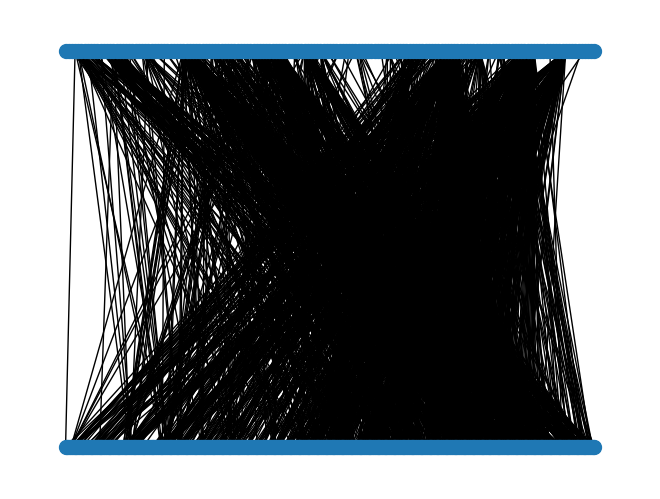

In [57]:
pos = nx.bipartite_layout(G, subset.ID_ANONIMO.unique(), align='horizontal')
nx.draw(G, pos, with_labels=False,  font_size=10, font_weight='bold', node_size=100)
#edge_labels = nx.get_edge_attributes(G, "weight")
#nx.draw_networkx_edge_labels(G, pos, edge_labels)
plt.show()